The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


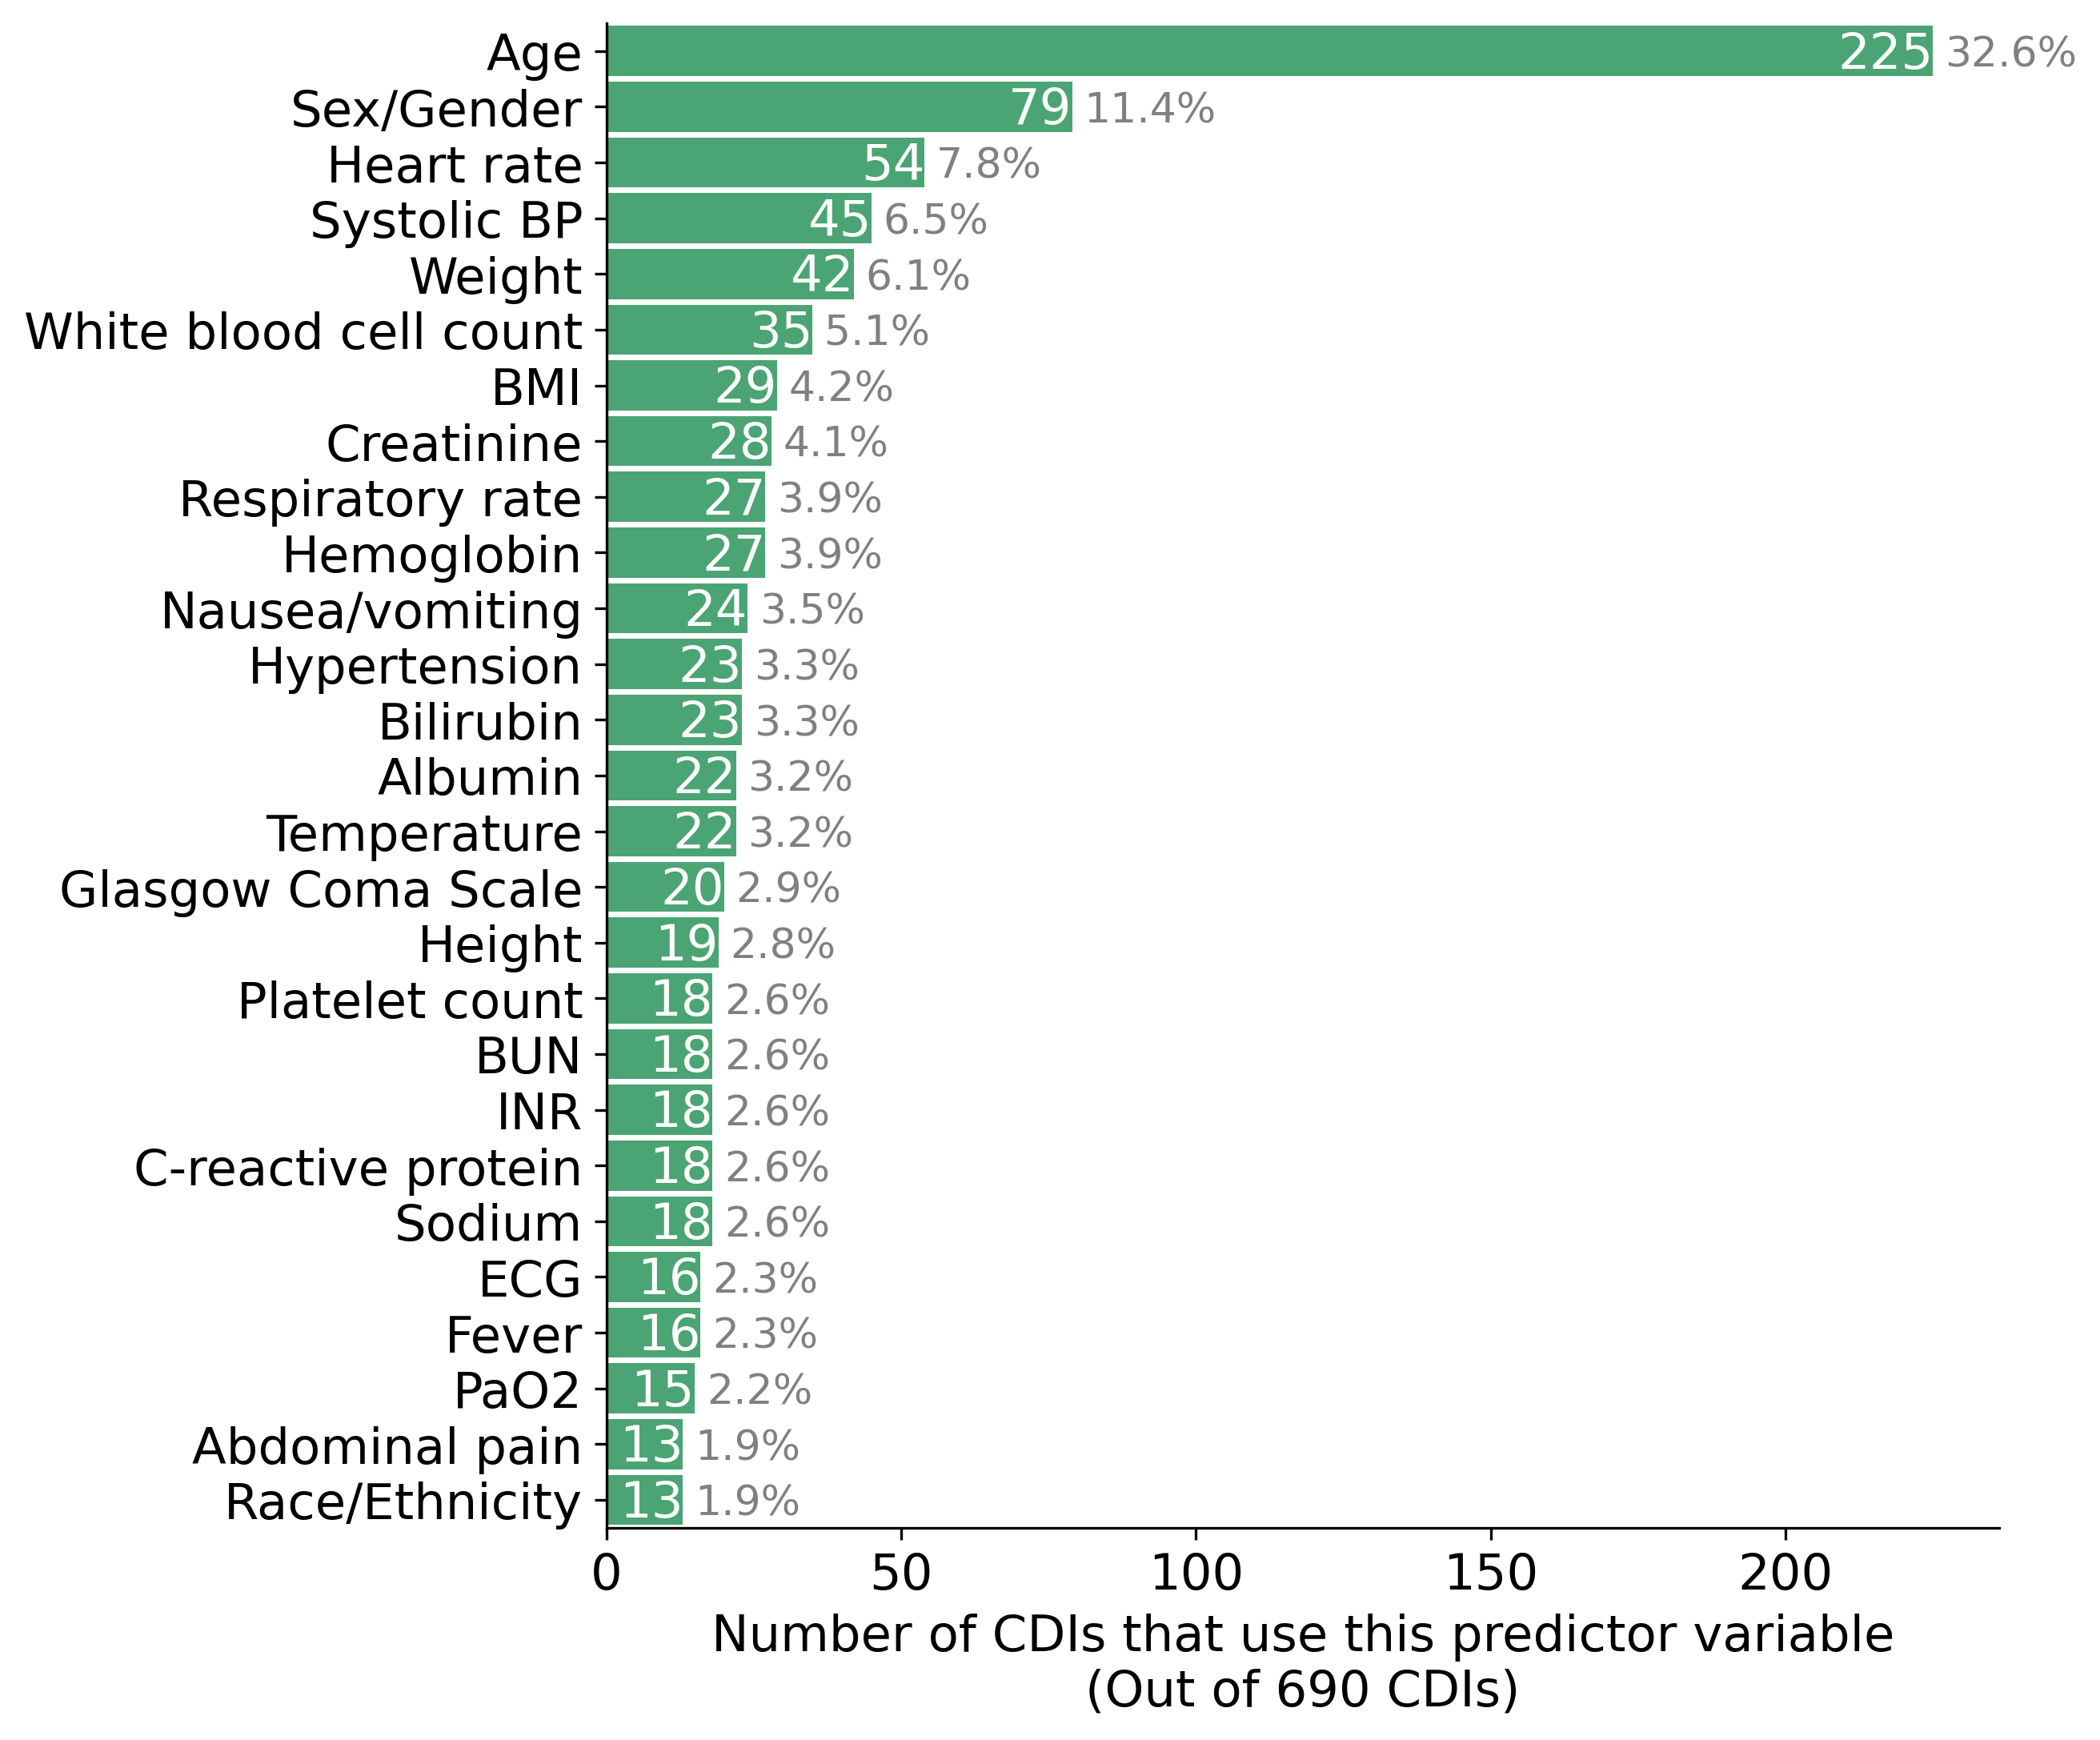

In [35]:
%load_ext autoreload
%autoreload 2


import dvu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from collections import defaultdict

import mdcalc
import viz

# plt.style.use('default')
dvu.set_style()

df = pd.read_pickle('../data/cdis_with_schemas_cleaned.pkl')

def get_feature_names_list(schema):
    if isinstance(schema, list):
        return [mdcalc.clean_feature_name(s['label_en']) if 'label_en' in s else 'unknown'
                for s in schema]
    else:
        return []

# these seem to be extra info in the calc, not actually a new feature
def remove_unknown(x):
    return [z for z in x if not z == 'unknown']

df['feature_names'] = df['input_schema'].apply(get_feature_names_list)
df['feature_names'] = df['feature_names'].apply(remove_unknown)
df['feature_names_unique_uncleaned'] = df['feature_names'].apply(lambda l: list(set(l)))
df['feature_names_unique'] = df['feature_names'].apply(
    lambda l: list(set([mdcalc.rename_feature_name(x) for x in l])))
df["feature_score_tuples_list"] = df["input_schema"].apply(
    mdcalc.get_feature_score_tuples_list_from_schema
)
df['num_features_unique'] = df['feature_names_unique'].apply(len)

# make plot
all_words = sum(df['feature_names_unique'], [])  # concatenate all list
all_words = pd.Series(all_words)
# all_words = all_words[~(all_words == 'unknown')] # not necessary, already handleed
counts = all_words.value_counts()
feat_names = pd.Series(counts.index)


counts.head(30)
plt.figure(figsize=(9, 7.5), dpi=300, facecolor='w')
N = 27
# plt.grid()
ax = sns.barplot(y=feat_names[:N].apply(lambda x: x[:39]),
                 x=counts.values[:N], orient='h', color='mediumseagreen', width=0.9)
# ax.bar_label(ax.containers[0], fontsize='small')
# bar_label inside of bar
# ax.bar_label(ax.containers[0], fontsize='small', labels=[str(x) + f' ({100 * x/df.shape[0]:.1f}%)' for x in counts.values[:N]])
# add text to each bar
# texts = [str(x) + f' ({100 * x/df.shape[0]:.1f}%)' for x in counts.values[:N]]
texts = [str(x) for x in counts.values[:N]]
for i, p in enumerate(ax.patches):
    ax.annotate(texts[i], (p.get_width(), p.get_y() + 0.75), ha='right', color='white')
texts_perc = [f'{100 * x/df.shape[0]:.1f}%' for x in counts.values[:N]]
for i, p in enumerate(ax.patches):
    ax.annotate(texts_perc[i], (p.get_width() + 2, p.get_y() + 0.72), ha='left', color='gray', fontsize='small')
plt.xlabel(f'Number of CDIs that use this predictor variable\n(Out of {df.shape[0]} CDIs)')
plt.tight_layout()
viz.savefig('common_features')

### Feature counts

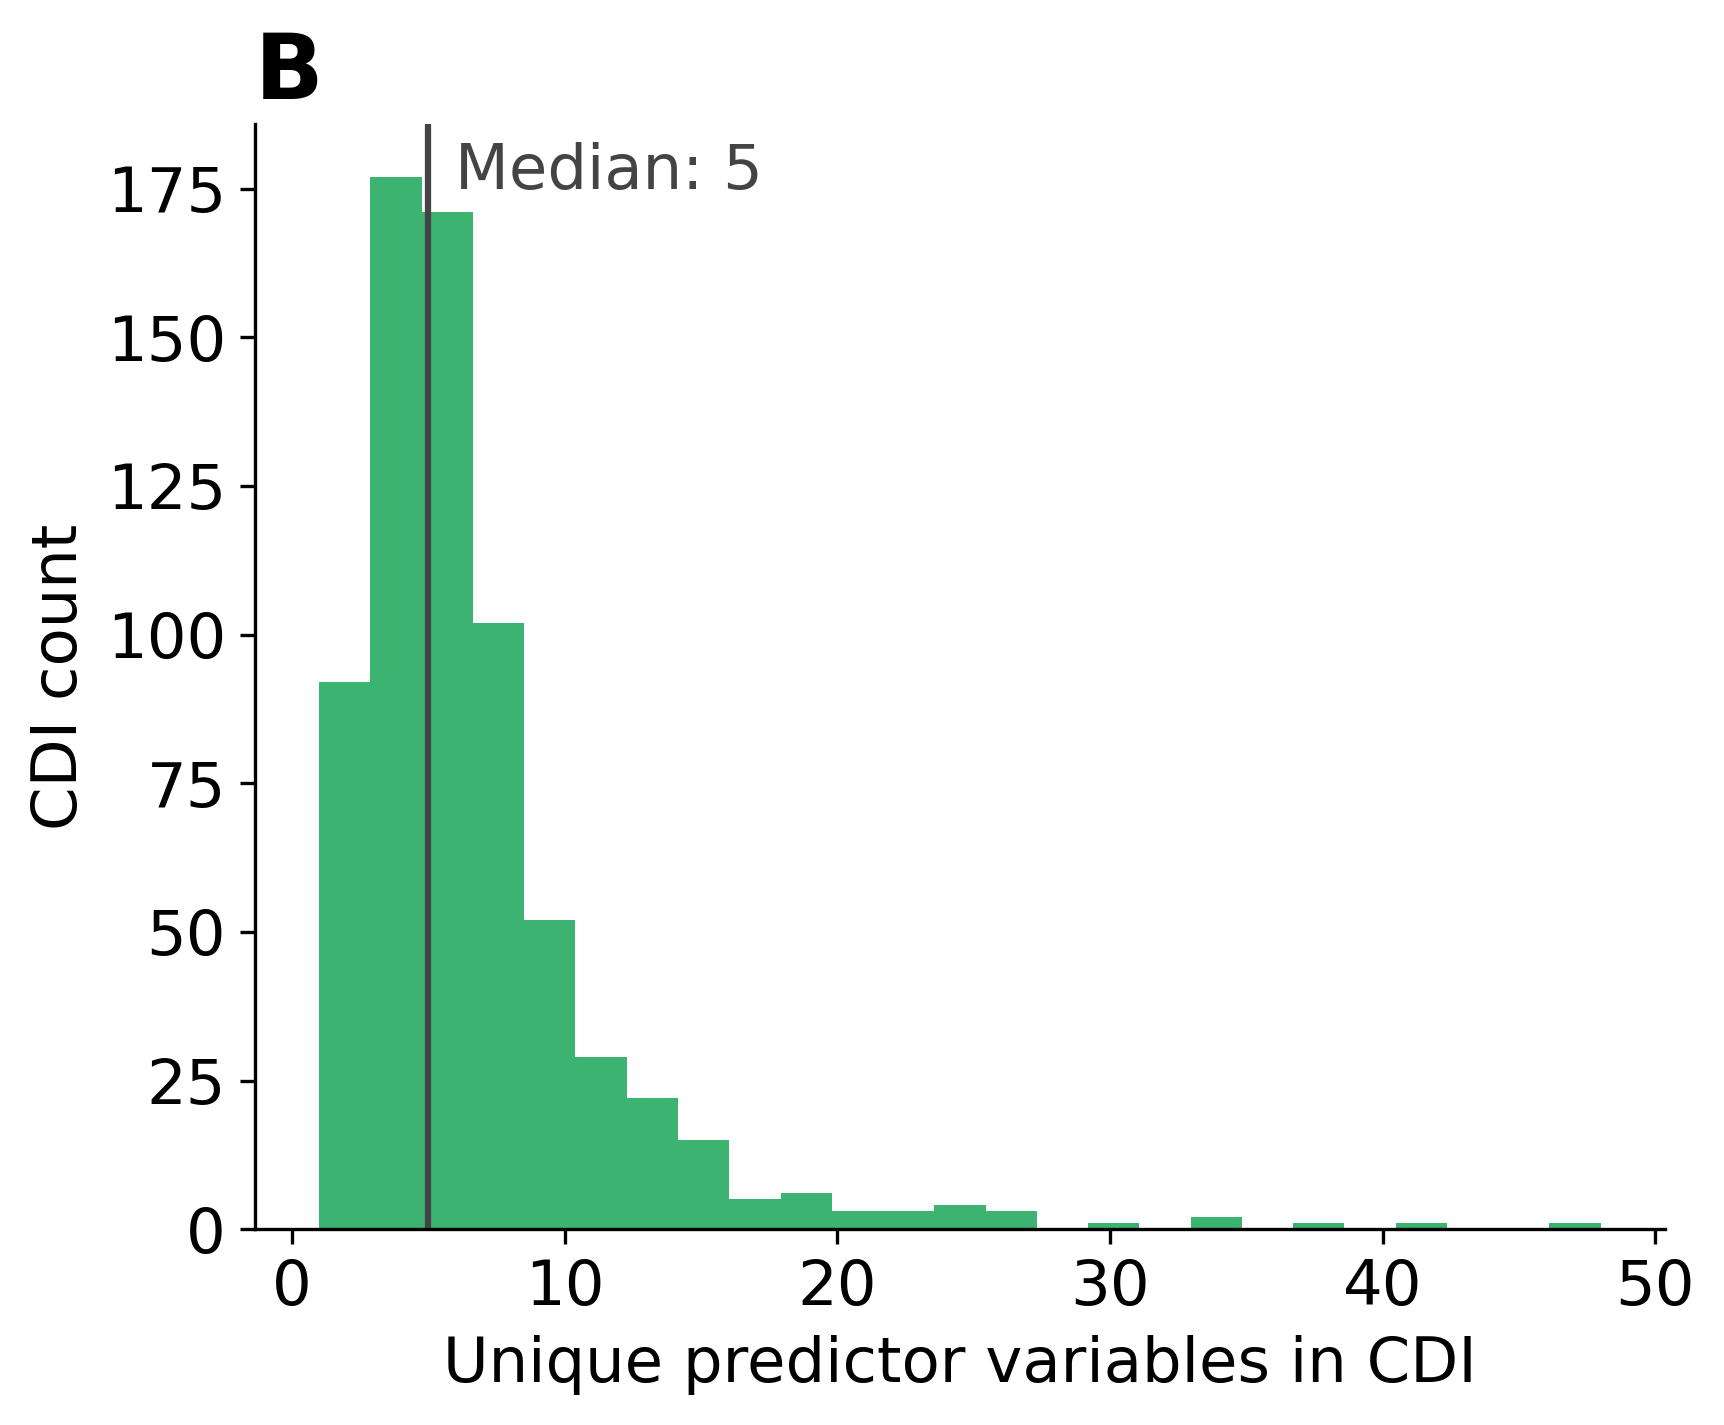

In [4]:
# df['num_splits'] = df['feature_names'].apply(len)

plt.figure(dpi=300, facecolor='w', figsize=(6, 5))
# plt.hist(df['num_splits'], label='Splits in CDI', bins=25)
avg = np.median(df['num_features_unique'])
plt.axvline(x=avg, ls='-', color='#444')
plt.text(s=f'Median: {avg:0.0f}', x=avg + 1, y=175, color='#444')
plt.hist(df['num_features_unique'], bins=25, color='mediumseagreen') #, alpha=0.8)
plt.xlabel('Unique predictor variables in CDI')
# plt.ylabel(f'Count of CDIs\n(out of {df.shape[0]} CDIs)')
plt.ylabel('CDI count')
plt.title('B', loc='left', fontsize='x-large', fontweight='bold')
plt.tight_layout()

# plt.legend()
viz.savefig('num_rules_hist')
# plt.show()

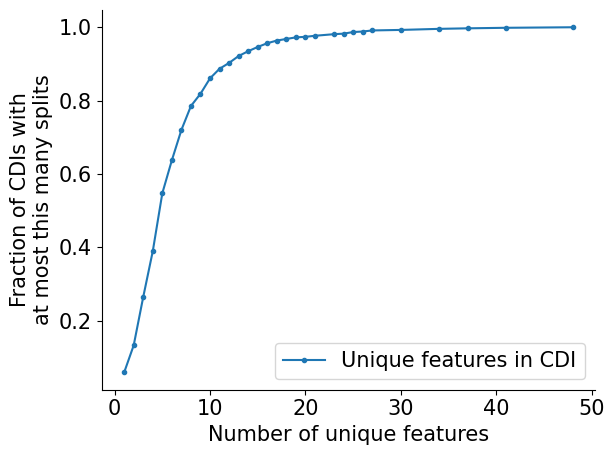

In [5]:
# vals, counts = np.unique(df['num_splits'], return_counts=True)
# plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Splits in CDI')
# val_90 = (np.cumsum(counts) / np.sum(counts)) >= 0.9

# plt.show()
vals, counts = np.unique(df['num_features_unique'], return_counts=True)
plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Unique features in CDI')

plt.xlabel('Number of unique features')
plt.ylabel('Fraction of CDIs with\nat most this many splits')
plt.legend()
viz.savefig('num_rules_cdf')
plt.show()

# Feature analysis

only keeping 310 CDIs out of 690


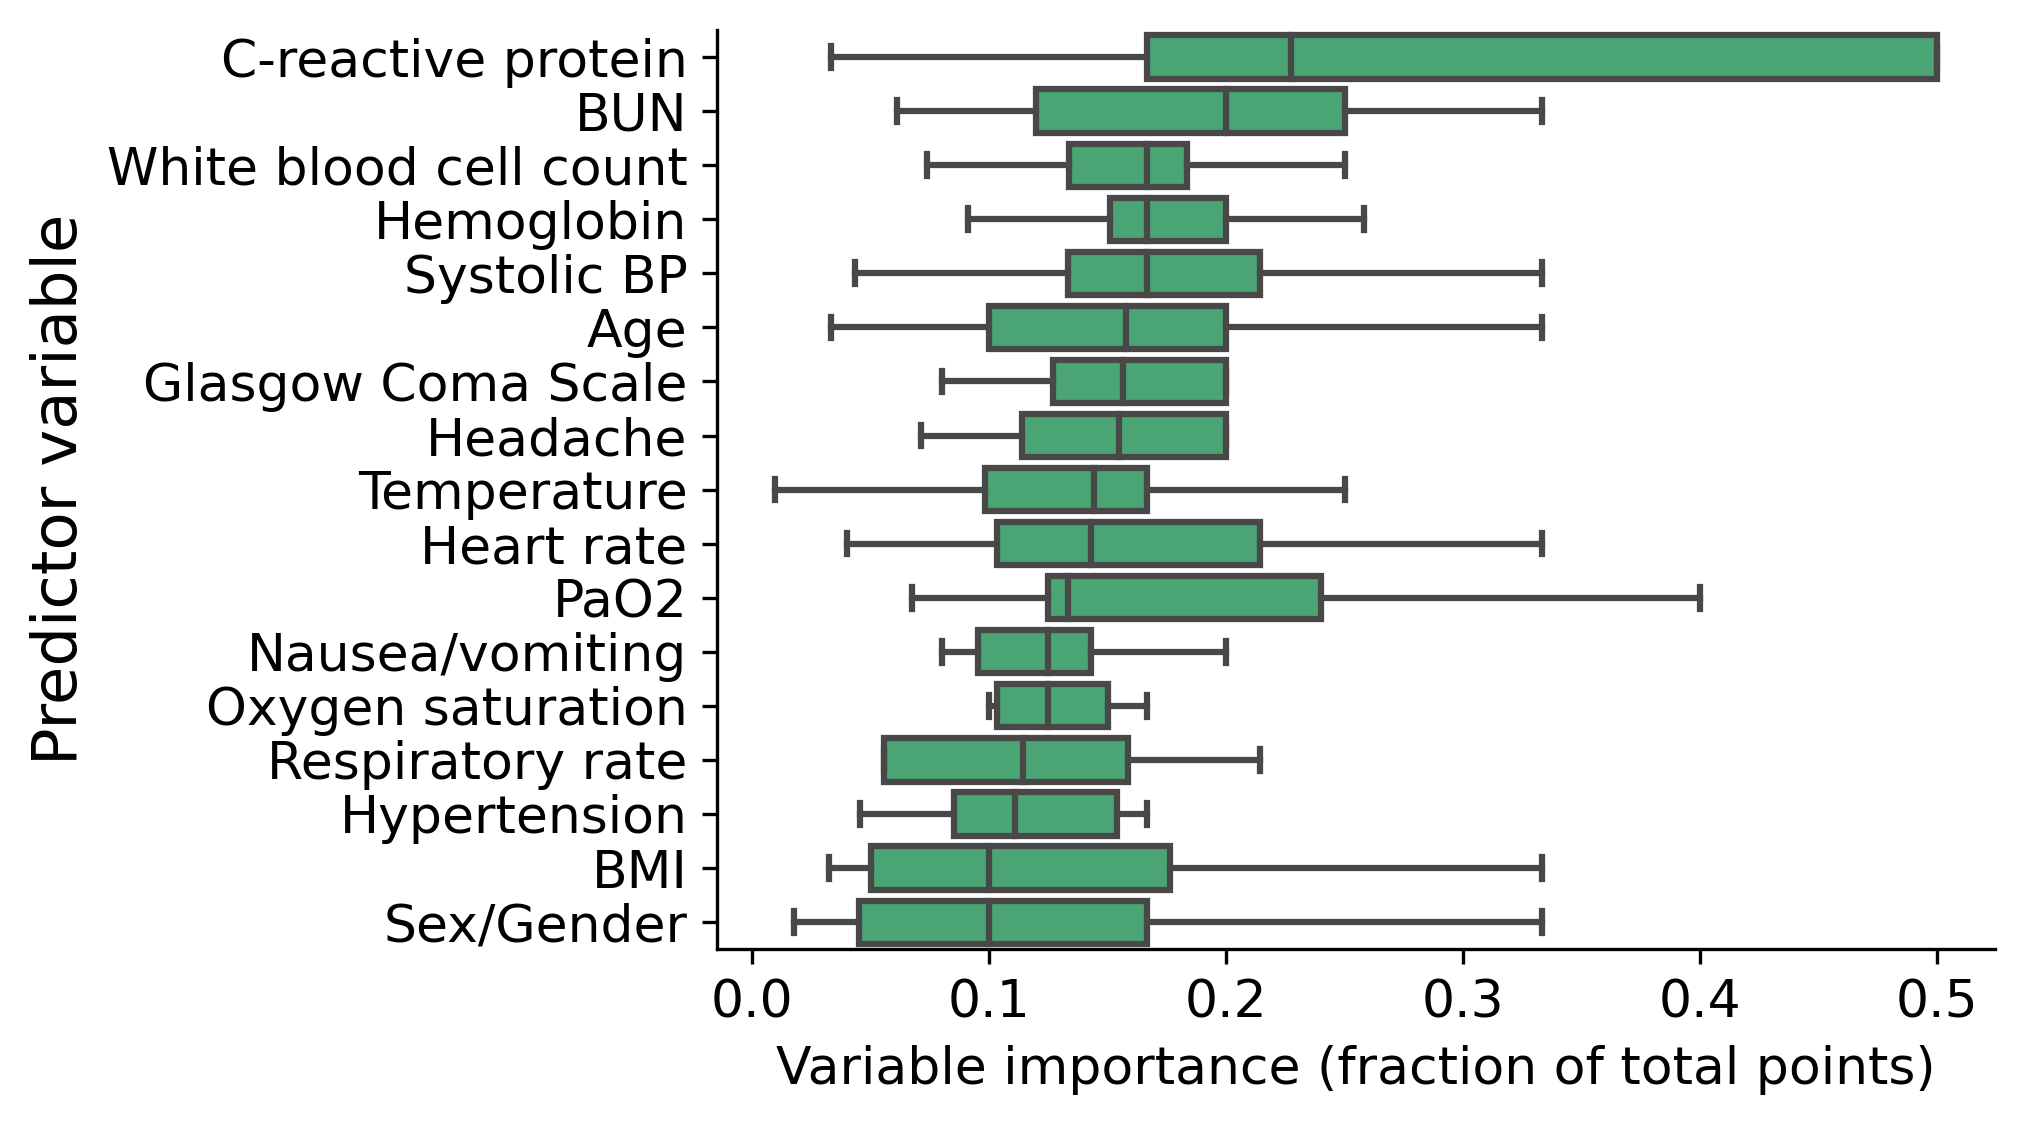

In [6]:
# only keep scoring-only CDIs
feature_score_tuples_list = df["feature_score_tuples_list"][
    df["feature_score_tuples_list"].apply(len) > 0
]
print("only keeping", feature_score_tuples_list.shape[0], "CDIs out of", df.shape[0])

# get score_dict
score_tuples = sorted(sum(feature_score_tuples_list, []), key=lambda x: x[0])
ks = sorted(set([score_tuple[0] for score_tuple in score_tuples]))
score_dict = defaultdict(list)
for key, score in score_tuples:
    score_dict[key].append(score)

# filter list
scores_list = [
    (k, v)
    for (k, v) in score_dict.items()
    if len(v) >= 9
    # or k == 'Race/Ethnicity'
]
# scores_list = sorted(score_dict_filt, key=lambda x: len(x[1]), reverse=True)

# format into df
feat_name_vec = sum([[k] * len(v) for (k, v) in scores_list], [])
score_vec = sum([v for (k, v) in scores_list], [])
df_box = pd.DataFrame.from_dict({"feat_name": feat_name_vec, "score": score_vec})
medians = df_box.groupby(["feat_name"])["score"].median().sort_values(ascending=False)

# plot
plt.figure(dpi=300, figsize=(7, 4))
# place grid in background behind other elements
sns.boxplot(
    x="score",
    y="feat_name",
    data=df_box,
    color="mediumseagreen",
    order=medians.index,
    # fliersize=3.1,
    whis=1.5,
    showfliers=False,

    # change color of fliers
    # flierprops=dict(alpha=1, marker='o', color='#EEE'),
)
plt.ylabel("Predictor variable")
plt.yticks(fontsize="small")
plt.xticks(fontsize="small")
plt.xlabel(
    "Variable importance (fraction of total points)",
    fontsize="small",
)
# plt.grid(axis="x")
plt.tight_layout()
viz.savefig("scoring_cdi_boxplot")

### Filter CDIs with potentially biased features

In [28]:
def check_fam_hist(x):
    return [s for s in x if "fam" in s.lower() and "history" in s.lower()]


df["fam_hist_var"] = df["feature_names_unique_uncleaned"].apply(check_fam_hist)
fam_hist = df["fam_hist_var"].apply(len) > 0
df['fam_hist_var'] = df['fam_hist_var'].apply(lambda x: str(x)[1: -1].replace("'", ""))
print(fam_hist.sum(), "family history CDIs")
d = df[["full_title_en", "short_description_en", "ref_text", "fam_hist_var"]][fam_hist].sort_index()
d.to_csv("../results/fam_hist_cdis.csv", index=False)
display(d)

10 family history CDIs


,full_title_en,short_description_en,ref_text,fam_hist_var
13,ACC/AHA Heart Failure Staging,Heart failure staging and therapy recommendati...,"Hunt SA, Baker DW et al. ACC/AHA Guidelines fo...",Patient with family history of cardiomyopathy
28,ASAS Criteria for Axial Spondyloarthritis (SpA),Axial SpA diagnosis.,"Rudwaleit M, Van Der Heijde D, Landewé R, et a...",Family history of SpA
29,ASAS Criteria for Peripheral SpondyloArthritis...,Peripheral SpA diagnosis.,"Rudwaleit M, Van der heijde D, Landewé R, et a...",Positive family history of SpA
113,CASPAR Criteria for Psoriatic Arthritis,Psoriatic arthritis diagnosis.,"Taylor W, Gladman D, Helliwell P, et al. Class...","Current psoriasis, personal history of psorias..."
133,Cambridge Diabetes Risk Score,T2DM risk.,"Griffin SJ, Little PS, Hales CN, Kinmonth AL, ...",Family history
140,Caprini Score for Venous Thromboembolism (2005),Stratifies risk of VTE in surgical patients.,"Caprini JA, Arcelus JI, Hasty JH, Tamhane AC, ...",Family history of thrombosis
192,Dutch Criteria for Familial Hypercholesterolem...,Diagnoses familial hypercholesterolemia.,World Health Organization. Familial hyperchole...,"Patient has elevated cholesterol, family histo..."
213,FINDRISC (Finnish Diabetes Risk Score),T2DM risk.,"Lindström J, Tuomilehto J. The diabetes risk s...",Family history of diabetes
426,Opioid Risk Tool (ORT) for Narcotic Abuse,Death or serious adverse events in COPD (ED se...,"Stiell IG, Clement CM, Aaron SD, et al. Clinic...","Family history of illegal drug abuse, Family h..."
617,Simon Broome Diagnostic Criteria for Familial ...,ICU mortality.,"Moreno RP, Metnitz PGH, Almeida E, et al. SAPS...","Family history of premature CVD events, Family..."


In [25]:
def check_race_ethnicity(x):
    return [s for s in x if mdcalc.rename_feature_name(s) == 'Race/Ethnicity']

df["race_var"] = df["feature_names_unique_uncleaned"].apply(check_race_ethnicity)
race = df["race_var"].apply(len) > 0
df['race_var'] = df['race_var'].apply(lambda x: str(x)[1: -1].replace("'", ""))
print(race.sum(), "race CDIs")
d = df[["full_title_en", "short_description_en", "ref_text", "race_var"]][race].sort_index()
d.to_csv("../results/race_cdis.csv", index=False)
display(d)

13 race CDIs


,full_title_en,short_description_en,ref_text,race_var
31,ASCVD (Atherosclerotic Cardiovascular Disease)...,10-year heart disease or stroke risk.,"Goff DC Jr, et. al. 2013 ACC/AHA Guideline on ...",Race
32,ASCVD (Atherosclerotic Cardiovascular Disease)...,10-year heart disease or stroke risk and stati...,"Goff DC Jr, et. al. 2013 ACC/AHA Guideline on ...",Race
75,Australian Type 2 Diabetes Risk (AUSDRISK) Ass...,Estimates diabetes risk.,"Chen L, Magliano DJ, Balkau B, Colagiuri S, Zi...",Ethnicity
122,CKD-EPI Equations for Glomerular Filtration Ra...,Estimates GFR.,"Levey AS, Stevens LA, Schmid CH, et al. A new ...",Race
126,COVID-19 Inpatient Risk Calculator (CIRC),Inpatient COVID mortality or severe disease pr...,"Garibaldi BT, Fiksel J, Muschelli J, et al. Pa...",White
180,Denver HIV Risk Score,HIV risk screening.,"Haukoos JS, Lyons MS, Lindsell CJ, et al. Deri...",Race/ethnicity
209,Estimated/Expected Peak Expiratory Flow (Peak ...,Quantifies asthma severity.,"Knudson RJ, Lebowitz MD, Holberg CJ, Burrows B...",Race/ethnicity
241,GWTG-Heart Failure Risk Score,Predicts in-hospital heart failure mortality.,"Peterson PN, et al. Circ Cardiovasc Qual Outco...",Black race
242,Gail Model for Breast Cancer Risk,Breast CA risk based on demographic and clinic...,"Gail MH, Brinton LA, Byar DP, Corle DK, Green ...","Asian-American sub race, Race/ethnicity"
323,Kinetic Estimated Glomerular Filtration Rate (...,Liver Transplant after acetaminophen OD.,"O'Grady J, Alexander G, Hayllar K, Williams R ...",Black race


### Output feature rename table

**Look at the renaming**

In [3]:
feats_print = sorted(set(sum(df['feature_names'], [])))
df_print = pd.DataFrame(feats_print, columns=['Original feature'])
df_print['Chandan rename'] = df_print['Original feature'].apply(mdcalc.rename_feature_name)
idxs_same = df_print['Chandan rename'] == df_print['Original feature']
df_print['Chandan rename'][idxs_same] = ''
df_print.to_csv('../data/renaming/features.csv', index=False)

In [ ]:
from mdcalc import (
    KEYWORDS_CONTAIN,
    KEYWORDS_CASED_CONTAIN,
    KEYWORD_PREFIXES,
    KEYWORDS_MAP,
    KEYWORD_PREFIXES_CASED_MAP,
    KEYWORD_RENAME_FINAL_MAP,
)

In [ ]:
d = {
    "KEYWORDS_CONTAIN": KEYWORDS_CONTAIN,
    "KEYWORDS_CASED_CONTAIN": KEYWORDS_CASED_CONTAIN,
    "KEYWORD_PREFIXES": KEYWORD_PREFIXES,
    "KEYWORDS_MAP": [f"{k} → {v}" for k, v in KEYWORDS_MAP.items()],
    "KEYWORD_PREFIXES_CASED_MAP": [f"{k} → {v}" for k, v in KEYWORD_PREFIXES_CASED_MAP.items()],
    "KEYWORD_RENAME_FINAL": [f"{k} → {v}" for k, v in KEYWORD_RENAME_FINAL_MAP.items()],
}
n = max(len(v) for v in d.values())
r = pd.DataFrame()
for k, v in d.items():
    r[k] = pd.Series(v)
r.to_csv("../data/renaming/keywords_export.csv", index=False)

### Feature debugging

In [ ]:
# example debugging schema
x = df[df.slug == 'cha2ds2-vasc-score-atrial-fibrillation-stroke-risk'].iloc[0]
schema = x['input_schema']
schema
for s in schema:
    options = s['options']
    print(s['name'], mdcalc.clean_feature_name(s['label_en']), [opt['value'] for opt in options])

In [ ]:
with pd.option_context("display.max_colwidth", 1000):
    # display(df[df["feature_score_tuples_list"].apply(len) == 2].iloc[3][['url_full', 'input_schema']])
    display(df[df["feature_score_tuples_list"].apply(len) == 2][['url_full', 'feature_score_tuples_list']].head())

In [ ]:
with pd.option_context("display.max_colwidth", 1000):
    slug = 'prognostic-index-cancer-outcomes'
    display(
        df[df.slug == slug][
            ["url_full", "input_schema", "feature_score_tuples_list"]
        ].iloc[0]
    )

In [ ]:
# display full
with pd.option_context("display.max_colwidth", 1000):
    # display(
    #     df.sort_values(by="num_features_unique", ascending=False)[
    #         ["url_full", "feature_names_unique", "slug", "input_schema"]
    #     ]
    # )
    display(
        df[df["feature_score_tuples_list"].apply(len) == 2][
            ["url_full", "feature_names_unique", "slug", "input_schema"]
        ]
    )